In [1]:
%load_ext autoreload
%autoreload 2

%load_ext nb_black

<IPython.core.display.Javascript object>

In [25]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

# import tensorflow_docs as tfdocs
# import tensorflow_docs.plots
# import tensorflow_docs.modeling

import scrinet.sample.sample_helpers as nn_help
import scrinet.sample.likelihood as likelihood
import scrinet.sample.kernels as kernel_helper


from scrinet.greedy import greedyrb
from scrinet.surrogate import surrogate
from scrinet.fits import nn, scale
from scrinet.interfaces import lalutils

from scrinet.analysis.timeseries_batch import TimeSeries
from scrinet.analysis.frequencyseries_batch import FrequencySeries
from scrinet.analysis import matchedfilter_batch as matchedfilter

from scrinet.workflow.pipe_utils import (
    init_logger,
    load_data,
    match,
    wave_sur_many,
    load_model,
)

from scrinet.workflow import generators
import schwimmbad
import functools
import tqdm
import os
import scrinet

<IPython.core.display.Javascript object>

In [3]:
sns.set_context("poster")
sns.set_style("darkgrid")

<IPython.core.display.Javascript object>

In [4]:
tfb = tfp.bijectors

<IPython.core.display.Javascript object>

In [5]:
rootdir = "/Users/Rhys/Documents/PhD/PE/NN_for_PE/3D_NP"

<IPython.core.display.Javascript object>

In [6]:
amp_basis = os.path.join(rootdir, "rb/amp/amp_eim_basis.npy")
amp_model_dir = os.path.join(rootdir, "ts/amp/fits")

phase_basis = os.path.join(rootdir, "rb/phase/phase_eim_basis.npy")
phase_model_dir = os.path.join(rootdir, "ts/phase/fits")

<IPython.core.display.Javascript object>

In [7]:
amp_model, amp_basis = load_model(
    basis_file=amp_basis,
    nn_weights_file=os.path.join(amp_model_dir, "best.h5"),
    X_scalers_file=os.path.join(amp_model_dir, "X_scalers.npy"),
    Y_scalers_file=os.path.join(amp_model_dir, "Y_scalers.npy"),
)

phase_model, phase_basis = load_model(
    basis_file=phase_basis,
    nn_weights_file=os.path.join(phase_model_dir, "best.h5"),
    X_scalers_file=os.path.join(phase_model_dir, "X_scalers.npy"),
    Y_scalers_file=os.path.join(phase_model_dir, "Y_scalers.npy"),
)

<IPython.core.display.Javascript object>

In [8]:
amp_basis = tf.convert_to_tensor(amp_basis, dtype=tf.float32)
phase_basis = tf.convert_to_tensor(phase_basis, dtype=tf.float32)

<IPython.core.display.Javascript object>

In [9]:
true_q = tf.constant([3.0, 0.8, 0.5], shape=(1, 3))
bad_q = tf.constant([5.0, 0.8, 0.05] * 2, shape=(2, 3))

<IPython.core.display.Javascript object>

In [10]:
sur_hp, _, _, _ = nn_help.generate_surrogate(
    true_q,
    amp_model=amp_model,
    amp_basis=amp_basis,
    phase_model=phase_model,
    phase_basis=phase_basis,
)


<IPython.core.display.Javascript object>

In [11]:
psd = tf.ones_like(sur_hp[0])
times = np.linspace(-10000, 100, 5000)

dt = times[1] - times[0]
n = len(times)
df = 1.0 / (n * dt)
norm = 4.0 * df
dt = tf.cast(dt, tf.float32)

<IPython.core.display.Javascript object>

In [12]:
y_true = tf.constant(sur_hp)
y_true = y_true + tf.random.normal(mean=0, stddev=0.1, shape=(len(y_true[0]),))


<IPython.core.display.Javascript object>

In [13]:
# @tf.function(experimental_compile=True, autograph=False, experimental_relax_shapes=True)
def target_log_prob_fn(x):
    
    log_like = likelihood.simple_gw_log_like(y_true,
                          x,
                          amp_model= amp_model,
                          amp_basis =amp_basis, 
                          phase_model = phase_model,
                          phase_basis = phase_basis, 
                          dt = dt, 
                          epoch = times[0])
    
    log_like = tf.cast(log_like, tf.float32)
    log_prior = likelihood.simple_gw_prior(x)

    prob = log_like + log_prior

    return tf.multiply(prob, 0.001)


<IPython.core.display.Javascript object>

In [14]:
num_chains = 5
ndim = 3
step_size = 0.0001

<IPython.core.display.Javascript object>

In [15]:
p0 = [
    [
        tf.random.uniform(shape=(1,), minval=0.0, maxval=1.0).numpy()[0],
        tf.random.uniform(shape=(1,), minval=0.0, maxval=1.0).numpy()[0],
        tf.random.uniform(shape=(1,), minval=0.0, maxval=1.0).numpy()[0],
        tf.random.uniform(shape=(1,), minval=0.0, maxval=0.2).numpy()[0],
    ]
    for i in range(num_chains)
]

<IPython.core.display.Javascript object>

In [16]:
p0 = [
    [
        tf.random.uniform(shape=(1,), minval=0.0, maxval=1.0).numpy()[0],
        tf.random.uniform(shape=(1,), minval=0.0, maxval=1.0).numpy()[0],
        tf.random.uniform(shape=(1,), minval=0.0, maxval=1.0).numpy()[0],
        tf.random.uniform(shape=(1,), minval=0.05, maxval=0.2).numpy()[0],
    ]
    for i in tf.range(num_chains)
]

<IPython.core.display.Javascript object>

In [17]:
p0 = tf.convert_to_tensor(p0)
p0 = tf.cast(p0, tf.float32)

<IPython.core.display.Javascript object>

In [21]:
target_log_prob_fn(p0)

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([  2.6276658, -93.07668  , -46.17904  , -15.302004 , -28.419756 ],
      dtype=float32)>

<IPython.core.display.Javascript object>

In [22]:
%%timeit
target_log_prob_fn(p0)

80.9 ms ± 32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>

In [26]:
@tf.function(experimental_compile=True, autograph=False)
def do_sampling(
    target_log_prob_fn,
    p0=p0,
    num_results=5 * 10 ** 3,
    num_burnin_steps=2 * 10 ** 3,
    ndim=3,
    step_size=0.001,
    sampler="HMC",
    step_size_adapter="simple",
    num_leapfrog_steps=10,
    max_tree_depth=8,
    parallel_iterations=20,
    target_accept_prob=0.7,
):

    if sampler == "HMC":

        kernel = kernel_helper.make_hmc_kernel(
            target_log_prob_fn,
            num_burnin_steps,
            step_size,
            step_size_adapter="simple",
            num_leapfrog_steps=num_leapfrog_steps,
            target_accept_prob=target_accept_prob,
        )

    if sampler == "MCMC":
        kernel = kernel_helper.make_rwmcmc_kernel(target_log_prob_fn)

    if sampler == "PTMCMC":
        raise NotImplementedError

    if sampler == "NUTS":
        kernel = kernel_helper.make_nuts_kernel(
            target_log_prob_fn,
            num_burnin_steps,
            step_size,
            step_size_adapter="simple",
            max_tree_depth=max_tree_depth,
            parallel_iterations=parallel_iterations,
            target_accept_prob=target_accept_prob,
        )

    posterior = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=p0,
        return_final_kernel_results=True,
        kernel=kernel,
    )

    return posterior

<IPython.core.display.Javascript object>

#### do a speed test with different tf function decorators combination

In [70]:
%%time
results = do_sampling(target_log_prob_fn = target_log_prob_fn,
                      num_results=  1 * 10 ** 3,
                      num_burnin_steps=5* 10 ** 2,
                      sampler = 'HMC')
trace = results.trace
p_accept = tf.reduce_mean(tf.exp(tf.minimum(trace.inner_results.log_accept_ratio, 0.0)))
print(f"Acceptance rate: {p_accept}")

2020-08-07 17:34:57,582 - WARNING - 11 out of the last 11 calls to <function x_scale_hack at 0x1a42e89f80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:34:57,670 - WARNING - 11 out of the last 11 calls to <function get_model_y_mean_scalers at 0x1a42e90200> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:34:57,683 - WARNING - 11 out of the last 11 calls to <function get_model_y_std_scalers at 0x1a42e900e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:34:57,693 - WARNING - 11 out of the last 11 calls to <function y_inv_scale_hack at 0x1a42e90320> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:34:57,737 - WARNING - 11 out of the last 11 calls to <function predict_hack at 0x1a42e89e60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:34:57,864 - WARNING - 11 out of the last 11 calls to <function x_scale_hack at 0x1a42e89f80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:34:58,016 - WARNING - 11 out of the last 11 calls to <function get_model_y_mean_scalers at 0x1a42e90200> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:34:58,028 - WARNING - 11 out of the last 11 calls to <function get_model_y_std_scalers at 0x1a42e900e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:34:58,039 - WARNING - 11 out of the last 11 calls to <function y_inv_scale_hack at 0x1a42e90320> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:34:58,064 - WARNING - 11 out of the last 11 calls to <function predict_hack at 0x1a42e89e60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:34:59,028 - WARNING - 11 out of the last 11 calls to <function x_scale_hack at 0x1a42e89f80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:34:59,190 - WARNING - 11 out of the last 11 calls to <function get_model_y_mean_scalers at 0x1a42e90200> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:34:59,208 - WARNING - 11 out of the last 11 calls to <function get_model_y_std_scalers at 0x1a42e900e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:34:59,244 - WARNING - 11 out of the last 11 calls to <function y_inv_scale_hack at 0x1a42e90320> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:34:59,275 - WARNING - 11 out of the last 11 calls to <function predict_hack at 0x1a42e89e60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:34:59,363 - WARNING - 11 out of the last 11 calls to <function x_scale_hack at 0x1a42e89f80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:34:59,487 - WARNING - 11 out of the last 11 calls to <function get_model_y_mean_scalers at 0x1a42e90200> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:34:59,499 - WARNING - 11 out of the last 11 calls to <function get_model_y_std_scalers at 0x1a42e900e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:34:59,514 - WARNING - 11 out of the last 11 calls to <function y_inv_scale_hack at 0x1a42e90320> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:34:59,560 - WARNING - 11 out of the last 11 calls to <function predict_hack at 0x1a42e89e60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


/Users/Rhys/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "
2020-08-07 17:35:01,512 - WARNING - 11 out of the last 11 calls to <function x_scale_hack at 0x1a42e89f80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:35:01,606 - WARNING - 11 out of the last 11 calls to <function get_model_y_mean_scalers at 0x1a42e90200> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:35:01,619 - WARNING - 11 out of the last 11 calls to <function get_model_y_std_scalers at 0x1a42e900e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:35:01,640 - WARNING - 11 out of the last 11 calls to <function y_inv_scale_hack at 0x1a42e90320> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:35:01,679 - WARNING - 11 out of the last 11 calls to <function predict_hack at 0x1a42e89e60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:35:01,716 - WARNING - 11 out of the last 11 calls to <function x_scale_hack at 0x1a42e89f80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:35:01,812 - WARNING - 11 out of the last 11 calls to <function get_model_y_mean_scalers at 0x1a42e90200> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:35:01,823 - WARNING - 11 out of the last 11 calls to <function get_model_y_std_scalers at 0x1a42e900e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:35:01,833 - WARNING - 11 out of the last 11 calls to <function y_inv_scale_hack at 0x1a42e90320> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:35:01,863 - WARNING - 11 out of the last 11 calls to <function predict_hack at 0x1a42e89e60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:35:02,471 - WARNING - 11 out of the last 11 calls to <function x_scale_hack at 0x1a42e89f80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:35:02,536 - WARNING - 11 out of the last 11 calls to <function get_model_y_mean_scalers at 0x1a42e90200> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:35:02,549 - WARNING - 11 out of the last 11 calls to <function get_model_y_std_scalers at 0x1a42e900e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:35:02,562 - WARNING - 11 out of the last 11 calls to <function y_inv_scale_hack at 0x1a42e90320> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:35:02,607 - WARNING - 11 out of the last 11 calls to <function predict_hack at 0x1a42e89e60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:35:02,662 - WARNING - 11 out of the last 11 calls to <function x_scale_hack at 0x1a42e89f80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:35:02,756 - WARNING - 11 out of the last 11 calls to <function get_model_y_mean_scalers at 0x1a42e90200> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:35:02,769 - WARNING - 11 out of the last 11 calls to <function get_model_y_std_scalers at 0x1a42e900e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:35:02,789 - WARNING - 11 out of the last 11 calls to <function y_inv_scale_hack at 0x1a42e90320> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-08-07 17:35:02,812 - WARNING - 11 out of the last 11 calls to <function predict_hack at 0x1a42e89e60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Acceptance rate: 0.8428980708122253
CPU times: user 8min 10s, sys: 14.3 s, total: 8min 24s
Wall time: 8min 42s


<IPython.core.display.Javascript object>

In [71]:
chains = results.all_states

<IPython.core.display.Javascript object>

In [72]:
results.final_kernel_results.new_step_size

<tf.Tensor: shape=(), dtype=float32, numpy=0.0013749393>

<IPython.core.display.Javascript object>

In [73]:
results.final_kernel_results.inner_results.is_accepted

<tf.Tensor: shape=(5,), dtype=bool, numpy=array([False,  True,  True,  True,  True])>

<IPython.core.display.Javascript object>

In [74]:
chains.numpy().T[0].shape

(5, 1000)

<IPython.core.display.Javascript object>

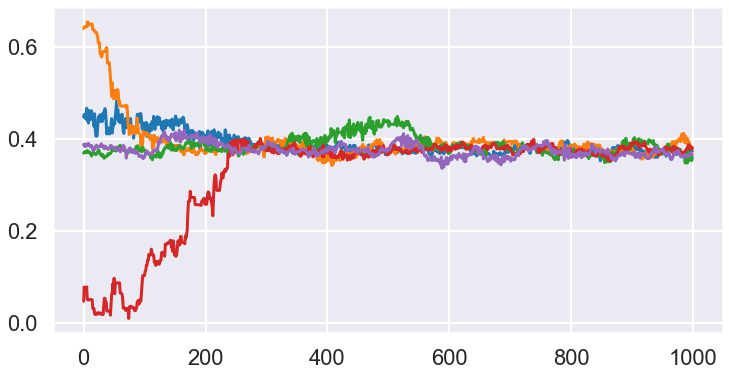

<IPython.core.display.Javascript object>

In [75]:
plt.figure(figsize=(12, 6))
for chain in chains.numpy().T[0]:
    plt.plot(chain)

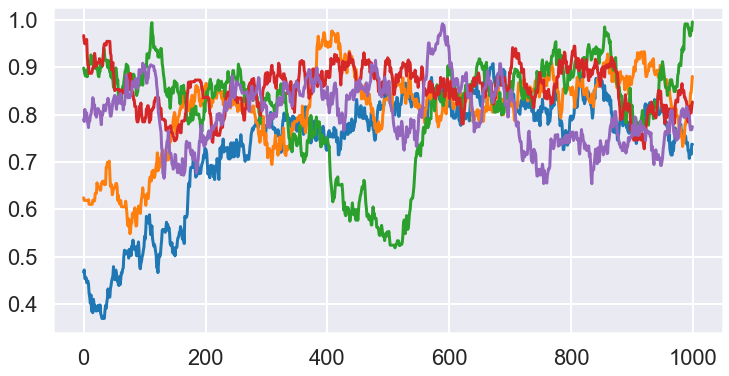

<IPython.core.display.Javascript object>

In [76]:
plt.figure(figsize=(12, 6))
for chain in chains.numpy().T[1]:
    plt.plot(chain)

In [77]:
plt.figure(figsize=(12, 6))
for chain in chains.numpy().T[2]:
    plt.plot(chain)

<IPython.core.display.Javascript object>

In [78]:
plt.figure(figsize=(12, 6))
for chain in chains.numpy().T[3]:
    plt.plot(chain)

<IPython.core.display.Javascript object>

In [79]:
data = nn_help.convert_tfp_chains_to_arviz_object(chains)

<IPython.core.display.Javascript object>

In [80]:
az.summary(data)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
x[0]  0.374  0.063   0.340    0.473      0.017    0.012      14.0    14.0   
x[1]  0.805  0.098   0.582    0.956      0.024    0.017      17.0    17.0   
x[2]  0.256  0.223   0.000    0.739      0.082    0.060       7.0     7.0   
x[3]  0.120  0.036   0.069    0.196      0.007    0.006      24.0    22.0   

      ess_bulk  ess_tail  r_hat  
x[0]      16.0      13.0   1.22  
x[1]      19.0      25.0   1.19  
x[2]       8.0      14.0   1.71  
x[3]      27.0      42.0   1.13

<IPython.core.display.Javascript object>

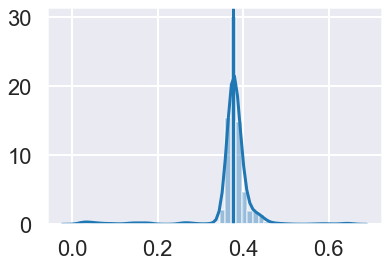

<IPython.core.display.Javascript object>

In [81]:
sns.distplot(chains.numpy().T[0].flatten())
plt.axvline(3.0 / 8)

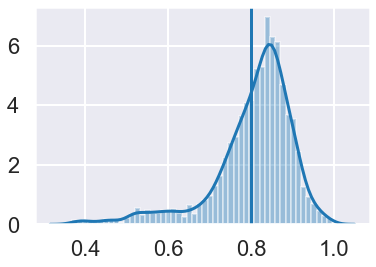

<IPython.core.display.Javascript object>

In [82]:
sns.distplot(chains.numpy().T[1].flatten())
plt.axvline(0.8)

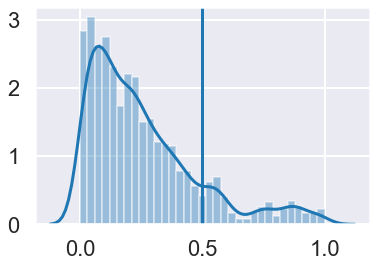

<IPython.core.display.Javascript object>

In [83]:
sns.distplot(chains.numpy().T[2].flatten())
plt.axvline(0.5)

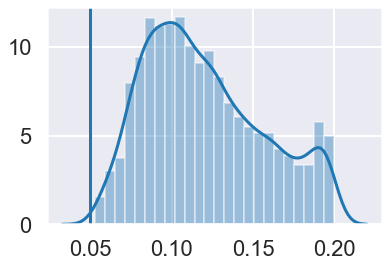

<IPython.core.display.Javascript object>

In [84]:
sns.distplot(chains.numpy().T[3].flatten())
plt.axvline(0.05)

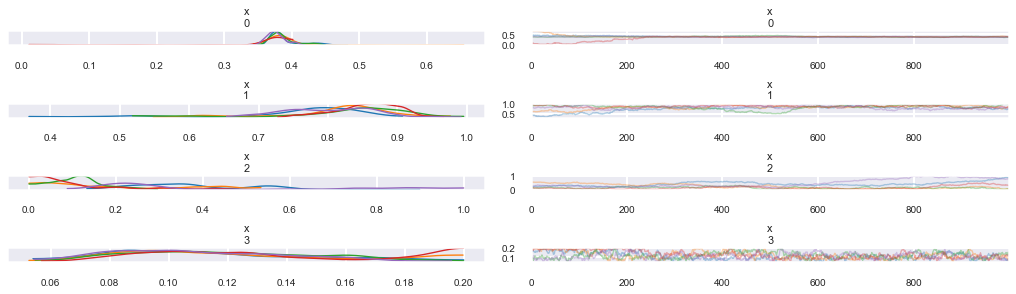

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1b519d6cd0>,
      dtype=object)

<IPython.core.display.Javascript object>

In [85]:
az.plot_trace(data, figsize=(14, 4), show=True)

In [86]:
az.plot_posterior(
    data, credible_interval=0.9,
)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1b52342150>,
      dtype=object)

<IPython.core.display.Javascript object>

In [87]:
az.plot_pair(data, kind="kde", diagonal=True, figsize=(14, 6))

/Users/Rhys/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/arviz/plots/pairplot.py:167: UserWarning: fill_last and contour will be deprecated. Please use kde_kwargs
  "fill_last and contour will be deprecated. Please use kde_kwargs", UserWarning,
/Users/Rhys/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/arviz/numeric_utils.py:127: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.diag(cov ** 0.5)
/Users/Rhys/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/arviz/numeric_utils.py:127: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.diag(cov ** 0.5)
/Users/Rhys/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/arviz/numeric_utils.py:127: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.diag(cov ** 0.5)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1b525cbf50>,
      dtype=object)

<IPython.core.display.Javascript object>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1b5218aed0>,
      dtype=object)

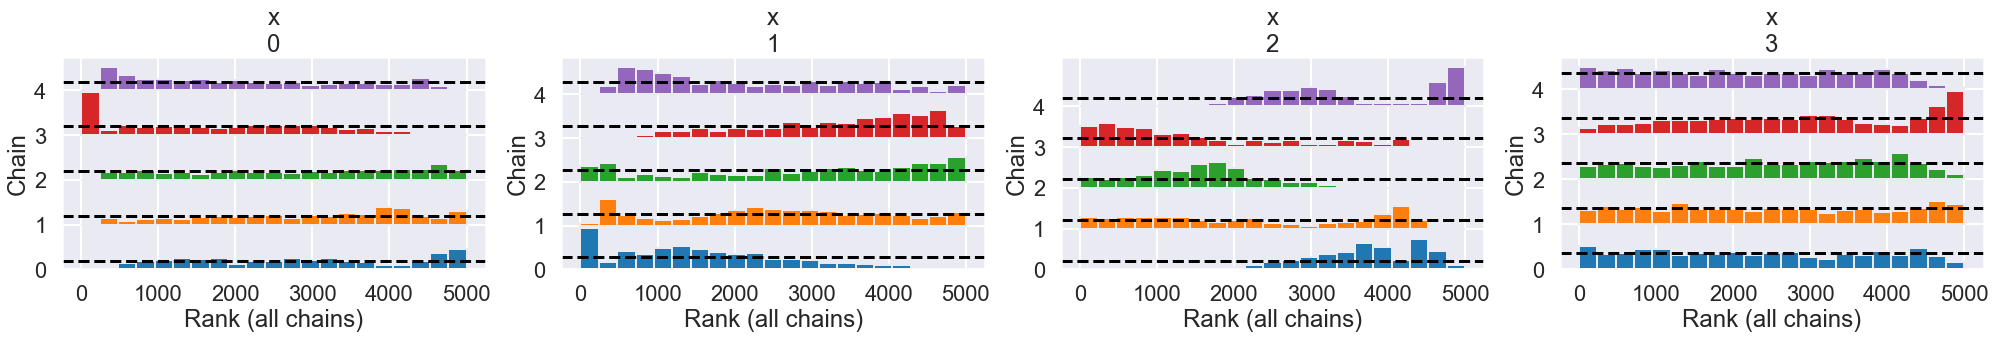

<IPython.core.display.Javascript object>

In [88]:
az.plot_rank(data)

In [89]:
az.ess(data)

<xarray.Dataset>
Dimensions:  (x_dim_0: 4)
Coordinates:
  * x_dim_0  (x_dim_0) int64 0 1 2 3
Data variables:
    x        (x_dim_0) float64 16.29 18.94 7.936 26.53

<IPython.core.display.Javascript object>

In [67]:
# az.rhat(data)

<IPython.core.display.Javascript object>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1b4faba5d0>,
      dtype=object)

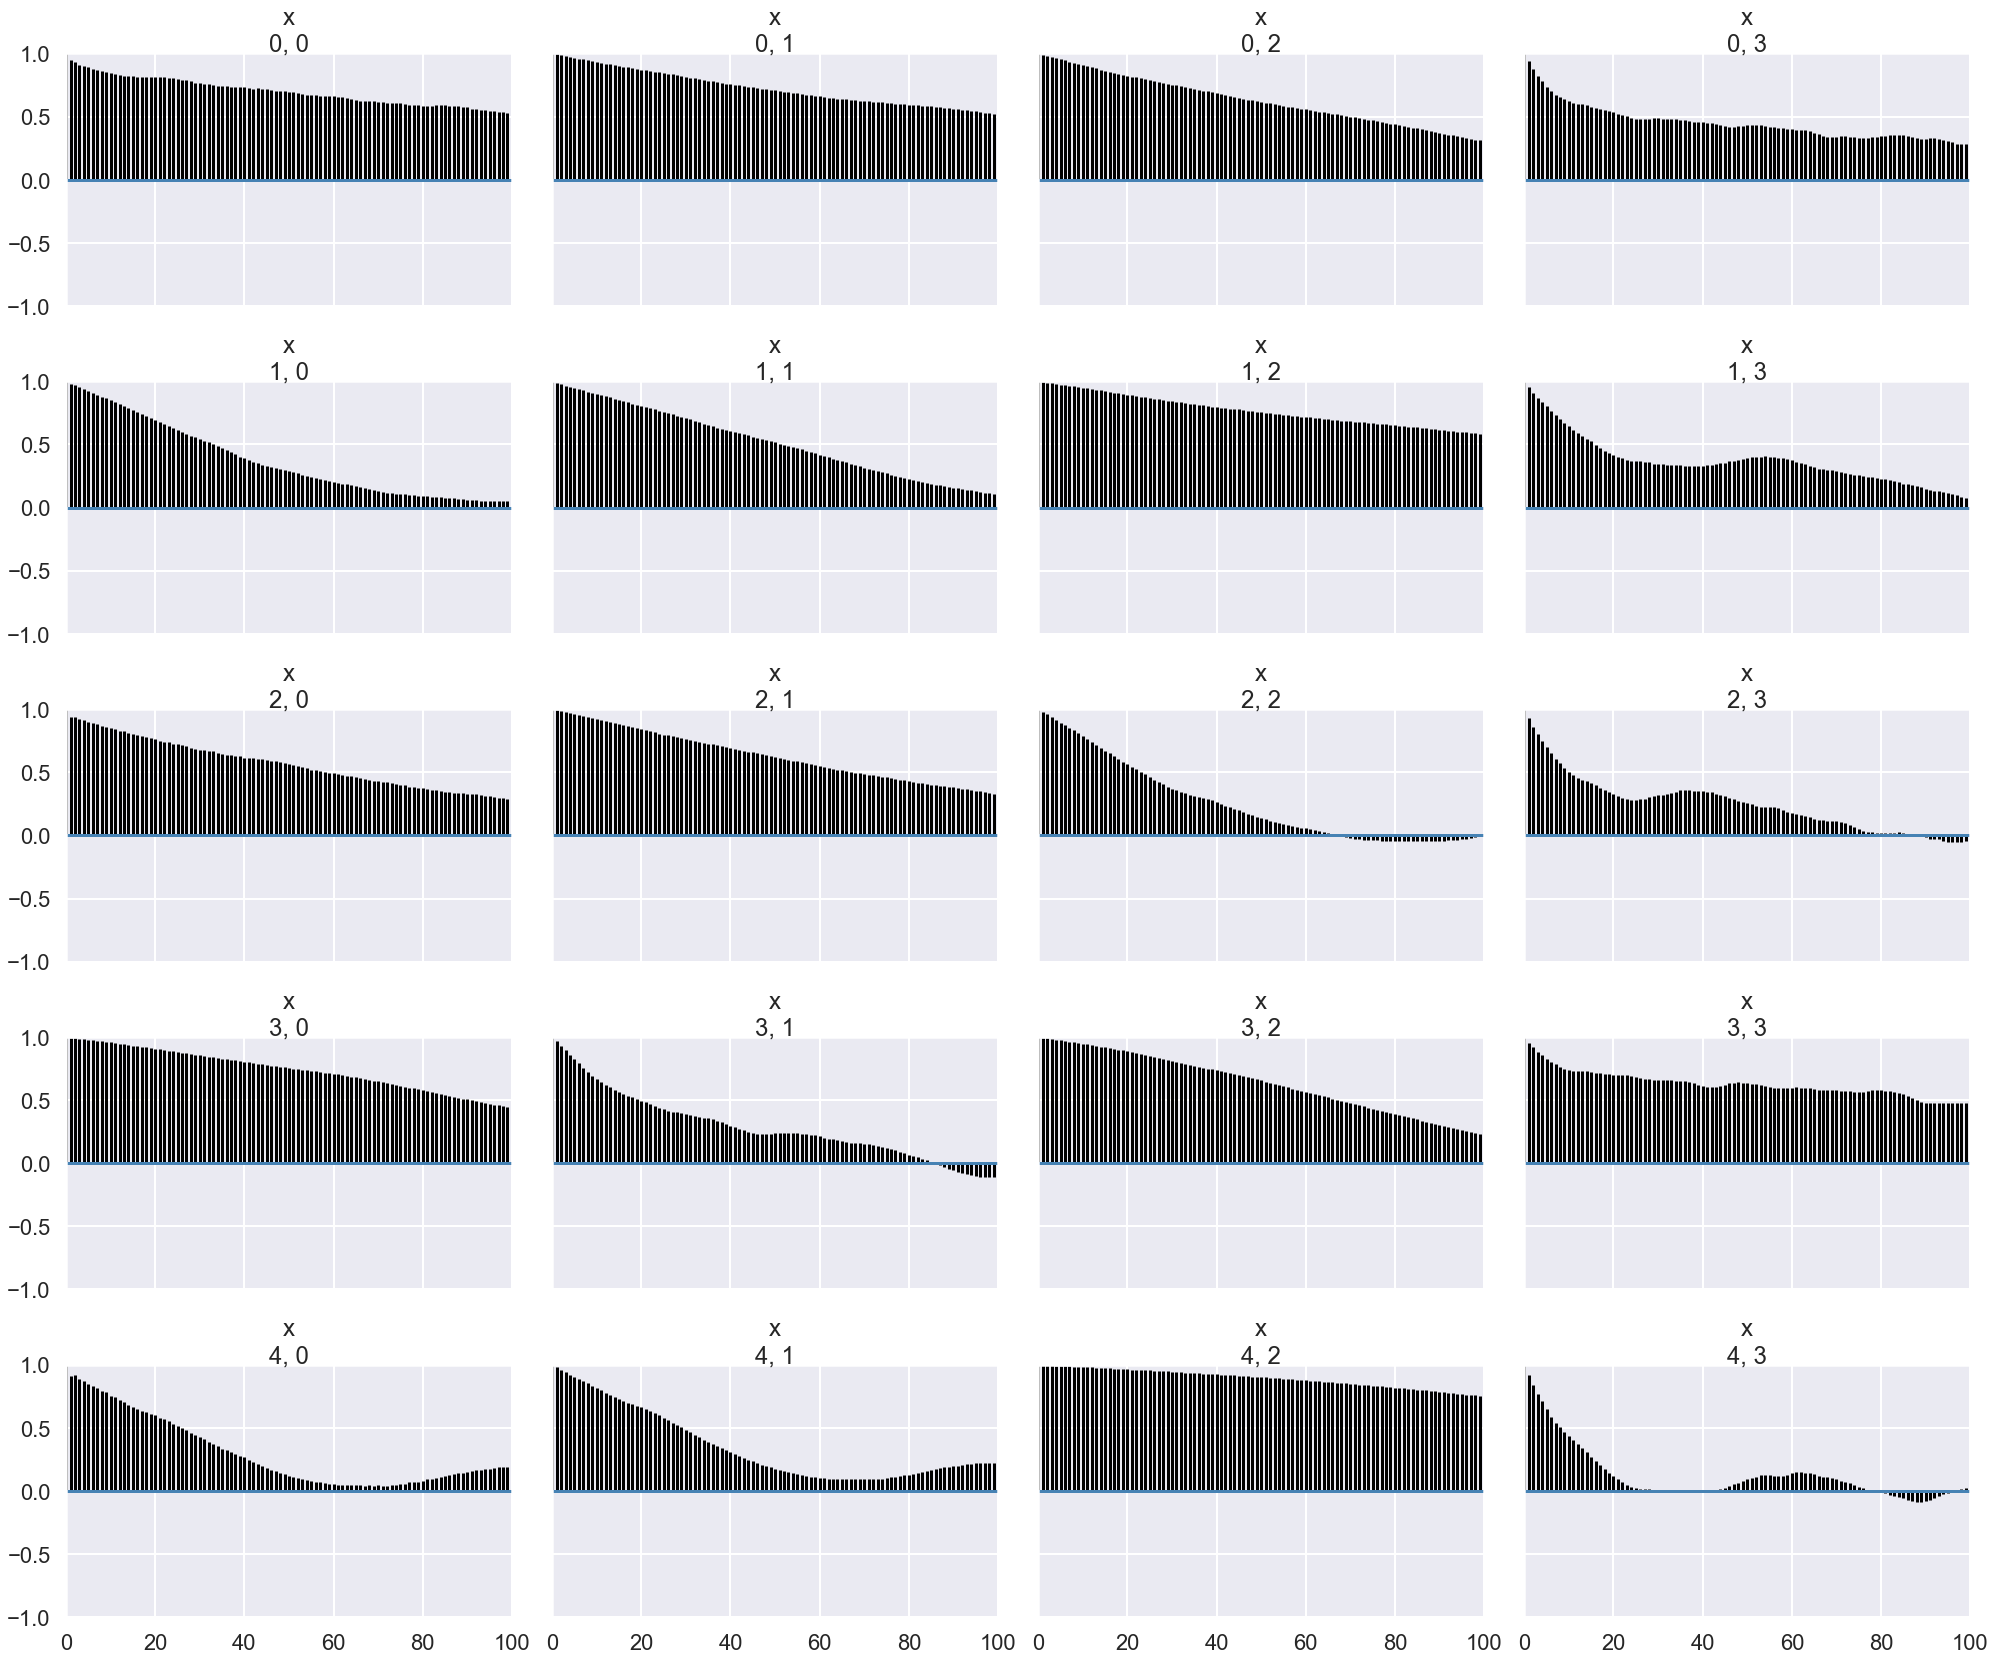

<IPython.core.display.Javascript object>

In [90]:
az.plot_autocorr(data)